# Unsupervised Classification Attempt

https://www.tutorialspoint.com/gensim/gensim_doc2vec_model.htm#:~:text=Doc2Vec%20model%2C%20as%20opposite%20to,the%20words%20in%20the%20sentence.
https://www.kaggle.com/code/currie32/predicting-similarity-tfidfvectorizer-doc2vec/notebook


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from gensim import utils
from gensim.models import Doc2Vec
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
bellingcat_df = pd.read_csv('../data/bellingcat.csv')
ceninfores = pd.read_csv('../data/ceninfores.csv')
get_geoconfirmed_data = pd.read_csv('../data/get_geoconfirmed_data.csv')
defmon = pd.read_csv('../data/defmon.csv')

In [3]:
bellingcat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1115 non-null   object 
 1   date         1115 non-null   object 
 2   latitude     1115 non-null   float64
 3   longitude    1115 non-null   float64
 4   place_desc   930 non-null    object 
 5   title        0 non-null      float64
 6   description  1115 non-null   object 
 7   source       1115 non-null   object 
 8   links        1115 non-null   object 
 9   filters      1115 non-null   object 
dtypes: float64(3), object(7)
memory usage: 87.2+ KB


In [4]:
ceninfores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10006 entries, 0 to 10005
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           10006 non-null  object 
 1   date         10006 non-null  object 
 2   latitude     10006 non-null  float64
 3   longitude    10006 non-null  float64
 4   place_desc   10006 non-null  object 
 5   title        0 non-null      float64
 6   description  10003 non-null  object 
 7   source       10006 non-null  object 
 8   links        10006 non-null  object 
 9   filters      10006 non-null  object 
dtypes: float64(3), object(7)
memory usage: 781.8+ KB


In [5]:
get_geoconfirmed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9047 entries, 0 to 9046
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   geoconfirmed_id  9047 non-null   object 
 1   icon             9047 non-null   object 
 2   id               9047 non-null   object 
 3   date             9047 non-null   object 
 4   latitude         9047 non-null   float64
 5   longitude        9047 non-null   float64
 6   place_desc       0 non-null      float64
 7   title            9047 non-null   object 
 8   description      9047 non-null   object 
 9   source           9047 non-null   object 
 10  links            9047 non-null   object 
 11  filters          9047 non-null   object 
dtypes: float64(3), object(9)
memory usage: 848.3+ KB


In [6]:
defmon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19272 entries, 0 to 19271
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           0 non-null      float64
 1   date         19272 non-null  object 
 2   latitude     19272 non-null  float64
 3   longitude    19272 non-null  float64
 4   place_desc   19170 non-null  object 
 5   title        19272 non-null  object 
 6   description  19255 non-null  object 
 7   source       19272 non-null  object 
 8   links        19272 non-null  object 
 9   filters      19272 non-null  object 
dtypes: float64(3), object(7)
memory usage: 1.5+ MB


In [7]:
stpwrd = stopwords.words('english')
new_stopwords = ["twitter", 'geoconfirmed', 'com', 'br', 'https', 'geo', 'png',
                 'status', 'vid', 'f', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
                'sep', 'oct', 'nov', 'dec', 'Æ', 'ô', 'ö', 'ò', 'û', 'ù', 'ÿ', 'á', 'í', 'ó', 'ú', 'ñ', 'Ñ', 'Š', 'š', 'ý', 'ü',
                'õ', 'ð', 'ã', 'Ý', 'Ü', 'Û', 'Ú', 'Ù', 'Ï', 'Î', 'Í', 'Ì', 'Ë', 'Ê', 'É', 'È', 'Å', 'Ä', 'Ã', 'Â', 'Á', 'À', 'Ö', 'Õ', 'Ô','Ó', 'Ò',
                'ÂƒÆ', 'â', 'Âƒâ', 'šâ', 'šÂ', 'Ž', 'žÂ', 'ÃƒÆ', 'Ãƒâ', 'ƒ', 'šÃ'  ] #add update to this
stpwrd.extend(new_stopwords)

In [8]:
def review_to_wordlist(review, remove_stopwords=True):
    # Clean the text, with the option to remove stopwords.
    
    # Convert words to lower case and split them
    words = review.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        words = [w for w in words if not w in stpwrd]
    
    review_text = " ".join(words)

    # Clean the text
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " 's ", review_text)
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    for i in new_stopwords:
        review_text = re.sub(i, " ", review_text)
    words = review_text.split()
    
    # Shorten words to their stems
    stemmer = SnowballStemmer('english', ignore_stopwords = True)
    stemmed_words = [stemmer.stem(word) for word in words]
    
    review_text = " ".join(stemmed_words)
    
    # Return a list of words
    return(review_text)

I need to pull out the title and description column for these data sources, and concatenate them into one massive file. I need to regex the words to get rid of artifact html text.

In [9]:
bellingcat_df['list_text'] = bellingcat_df['description']
ceninfores['list_text'] = ceninfores['description']
get_geoconfirmed_data['list_text'] = get_geoconfirmed_data['title'] + ' ' + get_geoconfirmed_data['description'] + get_geoconfirmed_data['icon']
defmon['list_text'] = defmon['title'] + ' ' + defmon['description']

In [10]:
#I need to drop the first 16 characters from each element in the geoconfirmed list. It is messing up the clustering I think
get_geoconfirmed_data['list_text'] = get_geoconfirmed_data['list_text'].str.slice(start=16)

In [11]:
#review text and create a dataframe of post features, just doing it for geoconfirmed right now
postfeatures = []

for i in get_geoconfirmed_data['list_text']:
    postfeatures.append(review_to_wordlist(i, remove_stopwords=True))

In [12]:
postfeatures

['uav tank russian southern militari district ight inka donestk oblast background anoth use seem thermit 1621920764008988672 04 1823 1527 uav tank russian southern militari district ight inka donestk oblast background anoth use seem thermit circl e00000 ru 56 10',
 'uav tank russian southern militari district ight inka donestk oblast background anoth use seem thermit 1621920764008988672 04 1823 1527 uav tank russian southern militari district ight inka donestk oblast background anoth use seem thermit circl e00000 ru 56 41',
 'uav russian in antri shell ukrainian orc 1610664469587283974 04 0954 2022 uav russian in antri shell ukrainian orc circl 0051ca ua 56 10',
 'russian train logist vehicl mazyr belarus 3523 x98 boriskovichi belarus 15 1700 2022 circl e00000 ru 56 161',
 'russian train militari equip spot rechitsa tank armour personnel carrier various zil kamaz truck even excav seen plat orm 89xv pcc re yca belarus 21 0902 2022 circl e00000 ru 56 161',
 'train militari equip spot bel

In [13]:
#Weird but maybe useful :) vectorize them
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(postfeatures)

In [14]:
scores = []

for k in range(2, 12):
    cl = KMeans(n_clusters=k, random_state=42)
    cl.fit(X)
    inertia = cl.inertia_
    sil = silhouette_score(X, cl.labels_)
    
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette_score']

D:\Anaconda\envs\dsi_spatial\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\envs\dsi_spatial\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\envs\dsi_spatial\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\envs\dsi_spatial\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda\envs\dsi_spatial\lib\site-pa

In [15]:
score_df

,k,inertia,silhouette_score
0,2,8744.872443,0.006753
1,3,8695.856399,0.005456
2,4,8641.955099,0.005394
3,5,8605.055681,0.006602
4,6,8582.917696,0.007360
5,7,8558.215524,0.008563
6,8,8538.416726,0.006487
7,9,8518.208814,0.008444
8,10,8499.663429,0.007405
9,11,8484.756248,0.008567


I will go with a neighbor amount of 7, because that was the highest silhouette score (not by much though, and admittedly the scores are very low).

In [16]:
km = KMeans(n_clusters=7, random_state=42)
km.fit(X)
get_geoconfirmed_data['clusters'] = km.predict(X)

D:\Anaconda\envs\dsi_spatial\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
get_geoconfirmed_data.to_csv('../data/get_geoconfirmed_data_clusters.csv', index = False)

In [18]:
#The analyze the clusters

In [19]:
geoconfirmed_clusters = pd.read_csv('../data/get_geoconfirmed_data_clusters.csv')

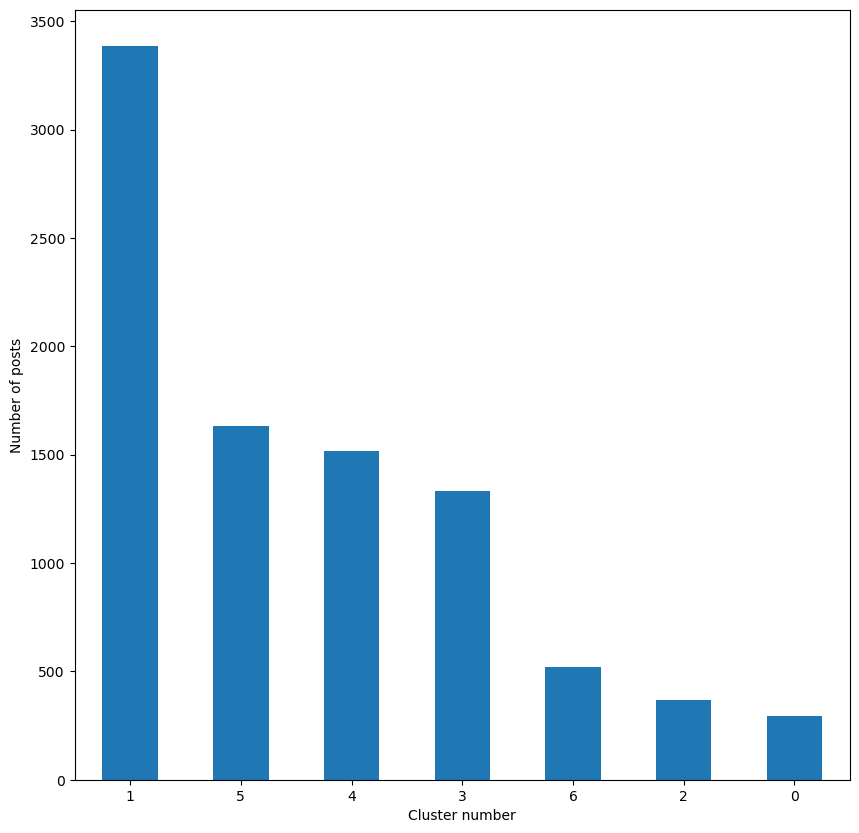

In [20]:
#Plot number of posts by cluster

plt.figure(figsize=(10,10))
geoconfirmed_clusters.groupby('clusters').size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=0)
plt.xlabel("Cluster number")
plt.ylabel("Number of posts")
plt.show()

In [21]:
stpwrd = stopwords.words('english')
new_stopwords = ["twitter", 'geoconfirmed', 'com', 'br', 'https', 'geo', 'png',
                 'status', 'vid', 'f', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 
                'sep', 'oct', 'nov', 'dec', 'Æ', 'ô', 'ö', 'ò', 'û', 'ù', 'ÿ', 'á', 'í', 'ó', 'ú', 'ñ', 'Ñ', 'Š', 'š', 'ý', 'ü',
                'õ', 'ð', 'ã', 'Ý', 'Ü', 'Û', 'Ú', 'Ù', 'Ï', 'Î', 'Í', 'Ì', 'Ë', 'Ê', 'É', 'È', 'Å', 'Ä', 'Ã', 'Â', 'Á', 'À', 'Ö', 'Õ', 'Ô','Ó', 'Ò',
                'ÂƒÆ', 'â', 'Âƒâ', 'šâ', 'šÂ', 'Ž', 'žÂ', 'ÃƒÆ', 'Ãƒâ', 'ƒ', 'šÃ'  ] #add update to this
stpwrd.extend(new_stopwords)

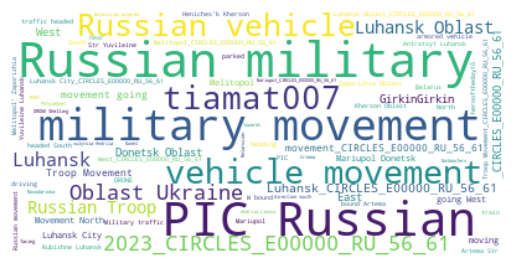

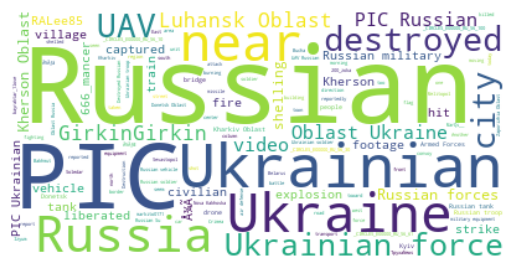

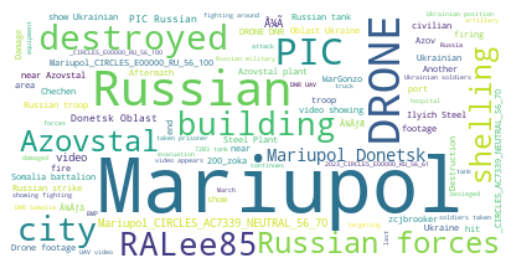

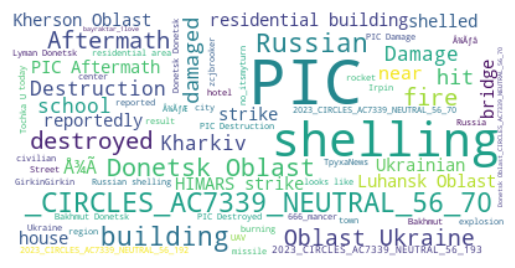

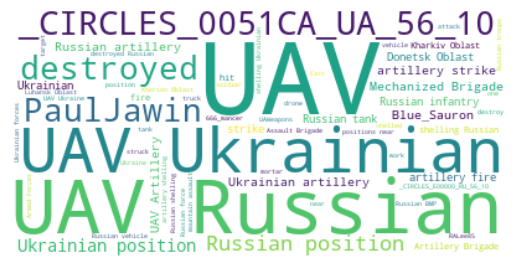

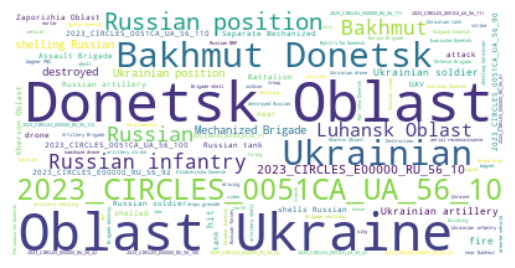

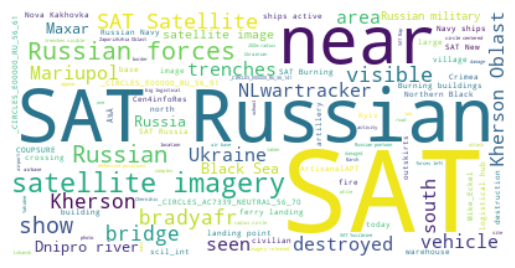

In [22]:
# Ten thousand records (almost) in the geoconfirmed data. Decently split too.
# Word cloud of each of the clusters
# https://www.datacamp.com/tutorial/wordcloud-python

#sort through clusters and generate word clouds for each
for i in range(0, 7):
    geoconfirmed_loop = geoconfirmed_clusters.loc[geoconfirmed_clusters['clusters'] == i]
    text = " ".join(text for text in geoconfirmed_loop.list_text)
    wordcloud = WordCloud().generate(text)
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stpwrd, background_color="white").generate(text)

    # Display the generated image:
    # the matplotlib way:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

**In analyzing the word clouds (I got rid of most of the special characters), some slight patterns start to emerge.**
- Cluster 0 seems to be focused on Russian movements, troops, and vehicles.
- Cluster 1 seems to be focused on Russian and Ukrainian activity, agnostic of the type of activity. it also seems to be a catch-all cluster.
- Cluster 2 seems to be focused on Mariupol, one of the cities in Ukraine that was beseiged for months in 2022 before surrendering to the Russians. Spatial and temporal analysis should shed light on this cluster.
- Cluster 3 seems to be focused on destruction caused by shelling and artillery, but not necessarily one-sided or the other.
- Cluster 4 seems to be Ukrainian positions and actions its military takes, including Unmanned Aerial Vehicles (UAV) activity.
- Cluster 5 Seems to be specific activities and attacks related to Russian and Ukranian militaries in Donetsk Oblast, specifically the city of Bakhmut in that province.
- Cluster 6 largely focuses on what satelite imagery can glean, such as ships, positions, and noteworthy positions like bridges, rivers, and airports.